医院感染数据整理

In [24]:
import pandas as pd 
import numpy as np

# matplotlib、seaborn、plotly都是绘图工具
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# 指定字体
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


font_path = 'C:\Windows\Fonts\msyh.ttc'  # 微软雅黑
font_prop = fm.FontProperties(fname=font_path, size=12)

en_font_path = 'C:\Windows\Fonts\TIMES.TTF'  # 新罗马字体 数字用
en_font_prop = fm.FontProperties(fname=en_font_path, size=12)




# --- Importing Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
import os
import yellowbrick
import joblib


from pywaffle import Waffle
from statsmodels.graphics.gofplots import qqplot
from PIL import Image
from highlight_text import fig_text
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC, ConfusionMatrix
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.style import set_palette

from catboost import CatBoostClassifier
import optuna
from sklearn.model_selection import cross_val_score

导入数据

In [25]:
df = pd.read_excel("D:/study/2023/infection/data/填补后数据.xlsx")
df.head()

,感染,性别,年龄,身高,体重,BMI,高血压,糖尿病,肿瘤,并发症种类,...,钠,氯,总二氧化碳浓度,手术时长,切口类型,有无进重症室,抗菌药物使用,联合用药,治疗用药已送细菌培养,住院天数
0,否,男,50,173.0,65.0,21.72,否,否,否,1,...,133.1,95.6,27.6,0.0,0,否,是,二联,是,31
1,否,男,24,173.0,73.0,24.39,否,否,否,1,...,134.8,98.6,25.8,0.0,0,否,否,无,否,27
2,否,男,49,180.0,80.0,24.69,否,否,否,1,...,142.4,108.0,25.4,2.0,1,否,否,无,否,5
3,否,男,30,160.0,95.0,37.11,是,否,否,1,...,140.1,105.7,24.1,3.0,2,否,是,二联,否,16
4,否,男,55,170.0,70.0,24.22,否,否,否,2,...,140.8,104.8,24.0,1.5,1,否,否,无,否,4


In [26]:

# 统计缺失值数量
missing=df.isnull().sum().reset_index().rename(columns={0:'missNum'})
# 计算缺失比例
missing['missRate']=missing['missNum']/df.shape[0]
# 按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy 存储的是每个变量缺失情况的数据框

In [27]:
#查看结局分部
df.感染.value_counts()

感染
否    1266
是      50
Name: count, dtype: int64

缺失值柱状图可视化

数据类型处理

In [28]:
# 获取所有列名
column_names = df.columns.tolist()

# 打印列名
print(column_names)

['感染', '性别', '年龄', '身高', '体重', 'BMI', '高血压', '糖尿病', '肿瘤', '并发症种类', '吸烟', '饮酒', '体温', '脉搏', '呼吸', '收缩压', '舒张压', '睡眠情况', '睡眠时间', '营养筛查NRS', '有创操作', '泌尿道插管', '气管插管', '动静脉导管', '血培养', '尿常规', '大便常规', '细菌培养', '白细胞', '中性粒细胞绝对值', '淋巴细胞绝对值', '红细胞', '血红蛋白', '血小板', '降钙素原', '血清白细胞介素6', '总蛋白', '白蛋白', '球蛋白', '白蛋白球蛋白比', '谷丙转氨酶', '谷草转氨酶', '总胆红素', '直接胆红素', '间接胆红素', '碱性磷酸酶', 'r.谷氨酰基转移酶', '尿素氮', '肌酐', '尿酸', '钾', '钠', '氯', '总二氧化碳浓度', '手术时长', '切口类型', '有无进重症室', '抗菌药物使用', '联合用药', '治疗用药已送细菌培养', '住院天数']


In [29]:
df['感染'].unique()

array(['否', '是'], dtype=object)

In [30]:
cat_var =["性别" , "高血压" ,"糖尿病" , "肿瘤" , "吸烟" , "饮酒"  , "睡眠情况","有创操作"  ,   "泌尿道插管" ,  
        "气管插管","动静脉导管", "血培养"  , "尿常规"    ,  "大便常规", "细菌培养" ,"降钙素原"  , "血清白细胞介素6", "切口类型"  , "有无进重症室",  "抗菌药物使用"  ,  
        "联合用药", "治疗用药已送细菌培养"]

num_var= ["年龄" , "身高" ,"体重"  , "BMI" , "并发症种类" ,"体温", "脉搏","呼吸","收缩压"  ,"舒张压",
           "睡眠时间" ,"营养筛查NRS","白细胞","中性粒细胞绝对值" ,"淋巴细胞绝对值","红细胞","血红蛋白" ,"血小板" ,
           "总蛋白","白蛋白" ,"球蛋白" , "白蛋白球蛋白比","谷丙转氨酶","谷草转氨酶","总胆红素","直接胆红素" ,"间接胆红素" ,"碱性磷酸酶" , "r.谷氨酰基转移酶" ,
           "尿素氮" , "肌酐" , "尿酸"  ,  "钾"  , "钠"   ,  "氯"  ,"总二氧化碳浓度" ,"手术时长" ,"住院天数"]

In [31]:
# 查看每列的数据类型
data_types = df.dtypes
print(data_types)


感染             object
性别             object
年龄              int64
身高            float64
体重            float64
               ...   
有无进重症室         object
抗菌药物使用         object
联合用药           object
治疗用药已送细菌培养     object
住院天数            int64
Length: 61, dtype: object


In [32]:
X = df.drop(['感染'], axis=1)
y_1 = df['感染']

In [33]:
from sklearn.preprocessing import LabelEncoder

# 创建LabelEncoder对象
label_encoder = LabelEncoder()

# 将目标变量编码为整数
y = label_encoder.fit_transform(y_1)


In [34]:
# from sklearn.preprocessing import StandardScaler, OrdinalEncoder
# encoder = OrdinalEncoder()
# X[cat_var]= encoder.fit_transform(X[cat_var])

In [35]:
# import matplotlib.pyplot as plt
# import seaborn as sns


# # 计算相关矩阵
# num_cols = X
# corr_mat = num_cols.corr()

# # 设置颜色映射和标签大小
# cmap = sns.diverging_palette(220, 20, as_cmap=True)
# sns.set(font_scale=1)

# # 绘制相关矩阵图
# plt.figure(figsize=(14,14))
# sns.heatmap(corr_mat, annot=False, cmap=cmap, center=0, square=True)

# # 应用中文和英文字体
# plt.title("数值型变量相关矩阵", fontsize=40, fontproperties=font_prop)  
# plt.xticks(rotation=90, fontproperties=font_prop, fontsize=10)  
# plt.yticks(rotation=0, fontproperties=font_prop, fontsize=10) 

# plt.tight_layout()
# plt.show()

# # 设定较低的阈值
# threshold = 0.7

# # 获取相关特征索引
# related_feat_idxs = np.where(abs(corr_mat) > threshold)
# related_feat_pairs = list(zip(related_feat_idxs[0], related_feat_idxs[1]))

# # 获取待移除的相关特征的索引
# features_to_remove = set()
# for i, j in related_feat_pairs:
#     if i != j and i not in features_to_remove and j not in features_to_remove:
#         features_to_remove.add(j)

# # 移除相关列
# X2 = X.drop(X.columns[list(features_to_remove)], axis=1)

# # 确认结果
# print("Original Shape:", X.shape)
# print("New Shape after Removing Correlated Features:", X2.shape)
# print("features to remove",X.columns[list(features_to_remove)])
# # 输出最终保留的变量名
# print("Final Features:", X2.columns)

In [36]:
X_dropped = X.drop(['谷草转氨酶', '联合用药'], axis=1)


In [37]:
X_train, X_test, Ytrain, Ytest = train_test_split(X_dropped, y, test_size=0.3, random_state=42)

In [38]:
cat_var2 =["性别" , "高血压" ,"糖尿病" , "肿瘤" , "吸烟" , "饮酒"  , "睡眠情况","有创操作"  ,   "泌尿道插管" ,  
        "气管插管","动静脉导管", "血培养"  , "尿常规"    ,  "大便常规", "细菌培养" ,"降钙素原"  , "血清白细胞介素6", "切口类型"  , "有无进重症室",  "抗菌药物使用" , "治疗用药已送细菌培养"]

num_var2= ["年龄" , "身高" ,"体重"  , "BMI" , "并发症种类" ,"体温", "脉搏","呼吸","收缩压"  ,"舒张压",
           "睡眠时间" ,"营养筛查NRS","白细胞","中性粒细胞绝对值" ,"淋巴细胞绝对值","红细胞","血红蛋白" ,"血小板" ,
           "总蛋白","白蛋白" ,"球蛋白" , "白蛋白球蛋白比","谷丙转氨酶","总胆红素","直接胆红素" ,"间接胆红素" ,"碱性磷酸酶" , "r.谷氨酰基转移酶" ,
           "尿素氮" , "肌酐" , "尿酸"  ,  "钾"  , "钠"   ,  "氯"  ,"总二氧化碳浓度" ,"手术时长" ,"住院天数"]

In [39]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
# Fit the encoder on the training set and transform it
cat_Train = encoder.fit_transform(X_train[cat_var2])

# Transform the test set based on the encoder fitted on the training set
cat_Test = encoder.transform(X_test[cat_var2])


In [40]:
# 打印出每个特征的映射关系
for i, cat in enumerate(cat_var2):
    mapping = {category: index for index, category in enumerate(encoder.categories_[i])}
    print(f"Feature '{cat}' mapping: {mapping}")

Feature '性别' mapping: {'女': 0, '男': 1}
Feature '高血压' mapping: {'否': 0, '是': 1}
Feature '糖尿病' mapping: {'否': 0, '是': 1}
Feature '肿瘤' mapping: {'否': 0, '是': 1}
Feature '吸烟' mapping: {'否': 0, '是': 1}
Feature '饮酒' mapping: {'否': 0, '是': 1}
Feature '睡眠情况' mapping: {'不正常': 0, '正常': 1}
Feature '有创操作' mapping: {'否': 0, '是': 1}
Feature '泌尿道插管' mapping: {'否': 0, '是': 1}
Feature '气管插管' mapping: {'否': 0, '是': 1}
Feature '动静脉导管' mapping: {'否': 0, '是': 1}
Feature '血培养' mapping: {'否': 0, '是': 1}
Feature '尿常规' mapping: {'否': 0, '是': 1}
Feature '大便常规' mapping: {'否': 0, '是': 1}
Feature '细菌培养' mapping: {'否': 0, '是': 1}
Feature '降钙素原' mapping: {'偏高': 0, '正常': 1}
Feature '血清白细胞介素6' mapping: {'偏高': 0, '正常': 1}
Feature '切口类型' mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
Feature '有无进重症室' mapping: {'否': 0, '是': 1}
Feature '抗菌药物使用' mapping: {'否': 0, '是': 1}
Feature '治疗用药已送细菌培养' mapping: {'否': 0, '是': 1}


In [41]:
from sklearn.preprocessing import StandardScaler
num_train=X_train[num_var2]
num_test=X_test[num_var2]
# 初始化特征缩放器
scaler = StandardScaler()

# 对训练集进行拟合和转换
X_train_scaled = scaler.fit_transform(num_train)

# 对测试集进行转换（只使用transform，不重新拟合）
X_test_scaled = scaler.transform(num_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=num_var2)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=num_var2)

cat_Test_df = pd.DataFrame(cat_Test, columns=cat_var2)
cat_Train_df = pd.DataFrame(cat_Train, columns=cat_var2)

In [42]:
print(type(cat_Test_df))  # 查看 cat_Test 的数据类型
print(type(X_test_scaled_df))  # 查看 X_test_scaled_df 的数据类型

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [43]:
Xtest = pd.concat([cat_Test_df, X_test_scaled_df], axis=1)
Xtrain = pd.concat([cat_Train_df,X_train_scaled_df],axis=1)

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve


def plot_evaluation_curves(model, X_train, y_train, X_test, y_test,y_pred,axes, algo_name):
    # 计算训练数据预测概率
    y_proba_train = model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
    auc_train = roc_auc_score(y_train, y_proba_train)

    # 计算测试数据预测概率
    y_proba_test = model.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
    auc_test = roc_auc_score(y_test, y_proba_test)

    # 绘制 ROC 曲线
    axes[0].plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.2f})'.format(auc_train))
    axes[0].plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.2f})'.format(auc_test))
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curve')
    axes[0].legend()

   
    # 使用 learning_curve 函数生成学习曲线数据
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5)

    # 计算平均得分和标准差
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # 绘制学习曲线
    axes[1].set_title('Learning Curve')
    axes[1].set_xlabel('Training Examples')
    axes[1].set_ylabel('Score')
    axes[1].grid()
    axes[1].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[1].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    axes[1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
    axes[1].legend(loc="best")

    # 添加主标题
    plt.suptitle(f'{algo_name} Performance Evaluation', fontsize=14, fontweight='bold')

    plt.tight_layout()

n_trials = 30

[I 2024-01-15 22:53:06,413] A new study created in memory with name: no-name-e96815f5-3be7-4eff-b807-8e35abf09813


Optimizing CatBoostClassifier...


[I 2024-01-15 22:53:10,640] Trial 0 finished with value: 0.9847943595769684 and parameters: {'depth': 3, 'learning_rate': 0.013264452018603231, 'random_strength': 10, 'iterations': 477}. Best is trial 0 with value: 0.9847943595769684.
[I 2024-01-15 22:53:14,597] Trial 1 finished with value: 0.991310223266745 and parameters: {'depth': 5, 'learning_rate': 0.17801380045254606, 'random_strength': 4, 'iterations': 327}. Best is trial 1 with value: 0.991310223266745.
[I 2024-01-15 22:54:54,854] Trial 2 finished with value: 0.9717743830787308 and parameters: {'depth': 11, 'learning_rate': 0.0014076000967357994, 'random_strength': 7, 'iterations': 256}. Best is trial 1 with value: 0.991310223266745.
[I 2024-01-15 22:55:02,635] Trial 3 finished with value: 0.9717743830787308 and parameters: {'depth': 6, 'learning_rate': 0.0017131620474786743, 'random_strength': 3, 'iterations': 491}. Best is trial 1 with value: 0.991310223266745.
[I 2024-01-15 22:55:33,191] Trial 4 finished with value: 0.984788

Best parameters for CatBoostClassifier:
{'depth': 6, 'learning_rate': 0.6045560827352852, 'random_strength': 2, 'iterations': 50}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       371
           1       1.00      0.75      0.86        24

    accuracy                           0.98       395
   macro avg       0.99      0.88      0.92       395
weighted avg       0.99      0.98      0.98       395



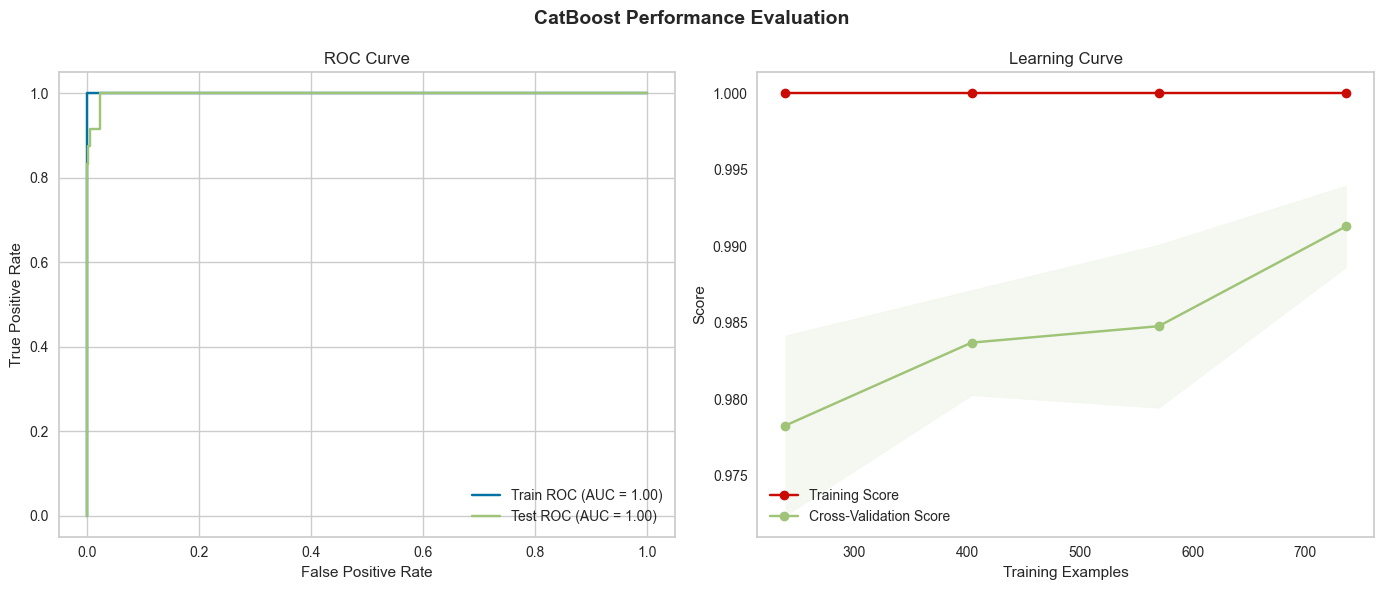

In [44]:
def cat_objective(trial):
    depth = trial.suggest_int("depth", 2, 12)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1)
    random_strength = trial.suggest_int("random_strength", 1, 10)
    iterations = trial.suggest_int("iterations", 50, 500)
    

    model = CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        random_strength=random_strength,
        iterations=iterations,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
        silent=True
    )
    score = cross_val_score(model, Xtrain, Ytrain, cv=5, n_jobs=-1).mean()
    return score

print("Optimizing CatBoostClassifier...")
cat_study = optuna.create_study(direction="maximize")
cat_study.optimize(cat_objective, n_trials=n_trials)

print("Best parameters for CatBoostClassifier:")
cat_best_params = cat_study.best_params
print(cat_best_params)

cat_clf = CatBoostClassifier(**cat_best_params, silent=True).fit(Xtrain, Ytrain)

cat_clf.fit(Xtrain, Ytrain)

# 使用模型进行预测
y_pred = cat_clf.predict(Xtest)

# --- Prediction and Accuracy ---
y_pred_train = cat_clf.predict(Xtrain)
y_pred_test = cat_clf.predict(Xtest)
acc_train = accuracy_score(y_pred_train, Ytrain)*100
acc_test = accuracy_score(y_pred_test, Ytest)*100
    
# --- Classification Report --- 
print(classification_report(Ytest, y_pred_test))
    

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_evaluation_curves(cat_clf, Xtrain, Ytrain, Xtest, Ytest,y_pred, axes, algo_name="CatBoost")
plt.show()

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV

# 初始化随机森林模型
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# 定义超参数网格
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 初始化RFECV
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=14)

# 创建包含 RFECV 和 GridSearchCV 的管道
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('feature_selection', rfecv),
    ('classification', GridSearchCV(model, param_grid=param_grid, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=14))
])

# 使用管道进行特征选择和模型选择
pipeline.fit(Xtrain, y_train)

# 输出最佳超参数组合
print("Best Parameters: ", pipeline.named_steps['classification'].best_params_)

# 获取最佳模型
best_model = pipeline.named_steps['classification'].best_estimator_

# 在测试集上应用 RFECV 特征选择
X_test_rfecv = pipeline.named_steps['feature_selection'].transform(Xtest)

# 使用最佳模型进行预测
y_pred = best_model.predict(X_test_rfecv)


# 在测试集上评估最佳模型性能
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print(report)

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9620253164556962
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       371
           1       1.00      0.38      0.55        24

    accuracy                           0.96       395
   macro avg       0.98      0.69      0.76       395
weighted avg       0.96      0.96      0.95       395



In [37]:
# 获取最佳特征数
optimal_num_features = rfecv.n_features_
print("Optimal Number of Features:", optimal_num_features)

# 假设你有原始的特征名称的列表
original_feature_names = column_names

# 使用已选择的特征布尔索引来获取已选择的特征名称
selected_feature_names = [original_feature_names[i] for i in range(len(rfecv.support_)) if rfecv.support_[i]]

print("Selected Features:")
print(selected_feature_names)

Optimal Number of Features: 56
Selected Features:
['性别', '年龄', '身高', '体重', 'BMI', '高血压', '糖尿病', '并发症种类', '吸烟', '饮酒', '体温', '脉搏', '呼吸', '收缩压', '舒张压', '睡眠情况', '睡眠时间', '营养筛查NRS', '有创操作', '泌尿道插管', '气管插管', '动静脉导管', '血培养', '尿常规', '大便常规', '细菌培养', '白细胞', '中性粒细胞绝对值', '淋巴细胞绝对值', '红细胞', '血红蛋白', '血小板', '降钙素原', '血清白细胞介素6', '总蛋白', '白蛋白', '球蛋白', '白蛋白球蛋白比', '谷丙转氨酶', '谷草转氨酶', '总胆红素', '直接胆红素', '间接胆红素', '碱性磷酸酶', 'r.谷氨酰基转移酶', '尿素氮', '肌酐', '尿酸', '钾', '钠', '氯', '总二氧化碳浓度', '手术时长', '切口类型', '有无进重症室', '抗菌药物使用']


Selected Features:
['性别', '年龄', '身高', '体重', 'BMI', '高血压', '糖尿病', '并发症种类', '吸烟', '饮酒', '体温', '脉搏', '呼吸', '收缩压', '舒张压', '睡眠情况', '睡眠时间', '营养筛查NRS', '有创操作', '泌尿道插管', '气管插管', '动静脉导管', '血培养', '尿常规', '大便常规', '细菌培养', '白细胞', '中性粒细胞绝对值', '淋巴细胞绝对值', '红细胞', '血红蛋白', '血小板', '降钙素原', '血清白细胞介素6', '总蛋白', '白蛋白', '球蛋白', '白蛋白球蛋白比', '谷丙转氨酶', '谷草转氨酶', '总胆红素', '直接胆红素', '间接胆红素', '碱性磷酸酶', 'r.谷氨酰基转移酶', '尿素氮', '肌酐', '尿酸', '钾', '钠', '氯', '总二氧化碳浓度', '手术时长', '切口类型', '有无进重症室', '抗菌药物使用']

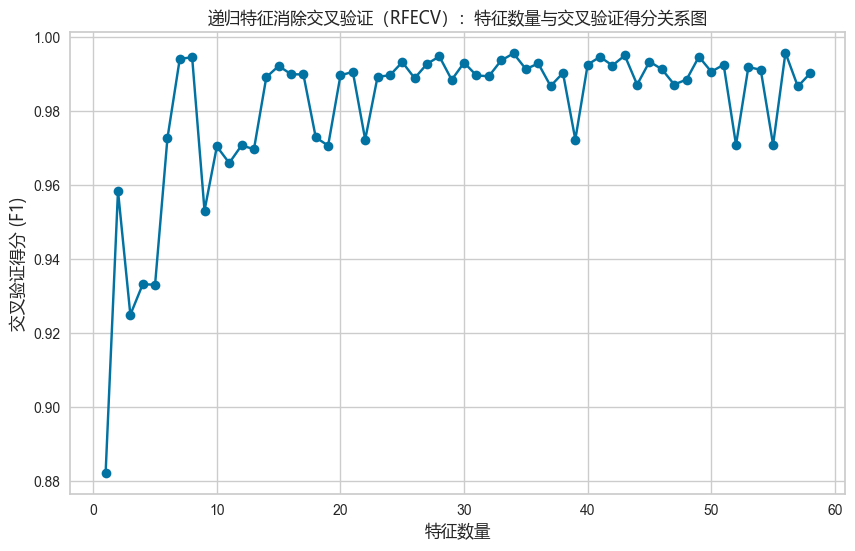

In [41]:
import matplotlib.pyplot as plt

# 获取 RFECV 的结果
rfecv_results = rfecv.cv_results_

# 获取每个特征数量
num_features = range(1, len(rfecv_results['mean_test_score']) + 1)

# 创建一个新的图形
plt.figure(figsize=(10, 6))

# 绘制特征数量与交叉验证得分的关系
plt.plot(num_features, rfecv_results['mean_test_score'], marker='o', linestyle='-', color='b')

# 添加标题和标签
plt.title('递归特征消除交叉验证（RFECV）：特征数量与交叉验证得分关系图', fontproperties=font_prop)
plt.xlabel('特征数量', fontproperties=font_prop)
plt.ylabel('交叉验证得分 (F1)', fontproperties=font_prop)

# 显示网格线
plt.grid(True)



# 显示图形
plt.show()

In [39]:
color_grid = 'gray'  # 根据需求选择合适的颜色值
color_line = 'black'
# --- Figures Settings ---
xy_label = dict(fontweight='bold', fontsize=12)
grid_style = dict(color=color_grid, linestyle='dotted', zorder=1)
title_style = dict(fontsize=14, fontweight='bold')
tick_params = dict(length=3, width=1, color=color_line)
color_yb = ['blue', 'yellow']